# Logistic Regression with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

## Build test and training sets & define preprocessing

In [8]:
NUM_WORDS = 50000
MAXLEN = 512
NGRAM_RANGE = 1

In [9]:
train, test, preproc = text.texts_from_csv('./data/train.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='./data/test.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE,
                                          preprocess_mode='bert')

detected encoding: utf-8 (if wrong, set manually)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Define and train the model

We'll need to dig into the ktrain code to determine what exactly they're doing.

In [10]:
model = text.text_classifier('bert', train, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

Is Multi-Label? False
maxlen is 512
done.


/Users/gregorytozzi/opt/anaconda3/lib/python3.7/site-packages/ktrain/__init__.py:94: UserWarning: For a GPU with 12GB of RAM, the following maxima apply:
        sequence len=64, max_batch_size=64
        sequence len=128, max_batch_size=32
        sequence len=256, max_batch_size=16
        sequence len=320, max_batch_size=14
        sequence len=384, max_batch_size=12
        sequence len=512, max_batch_size=6
        
        You've exceeded these limits.
        If using a GPU with <=12GB of memory, you may run out of memory during training.
        If necessary, adjust sequence length or batch size based on above.
  if wrn: I.warnings.warn(msg)


### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/Users/gregorytozzi/opt/anaconda3/lib/python3.7/site-packages/ktrain/core.py:464: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn('max_epochs is being set to 5 since steps per epoch is small. ' +\


Train on 647 samples
Epoch 1/5


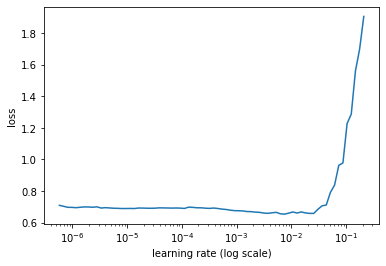

In [7]:
learner.lr_plot()

### Train

In [8]:
learner.autofit(0.02)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.02...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 0s 293us/sample - loss: 0.8082 - accuracy: 0.6770 - val_loss: 0.9527 - val_accuracy: 0.6790
Epoch 2/1024
647/647 [==============================] - 0s 149us/sample - loss: 0.3334 - accuracy: 0.8903 - val_loss: 0.7276 - val_accuracy: 0.7346
Epoch 3/1024
647/647 [==============================] - 0s 144us/sample - loss: 0.1383 - accuracy: 0.9567 - val_loss: 0.8855 - val_accuracy: 0.6914
Epoch 4/1024
512/647 [======================>.......] - ETA: 0s - loss: 0.0418 - accuracy: 0.9883
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 0.01 (if not early_stopping).
647/647 [==============================] - 0s 130us/sample - loss: 0.0386 - accuracy: 0.9892 - val_loss: 0.8051 - val_accuracy: 0.7346
Epoc

## Examine results

In [9]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.70      0.60      0.64        65
           1       0.75      0.82      0.79        97

    accuracy                           0.73       162
   macro avg       0.73      0.71      0.72       162
weighted avg       0.73      0.73      0.73       162



array([[39, 26],
       [17, 80]])

In [10]:
import pandas as pd
X_test = pd.read_csv('./data/test.csv')['cleaned_contents']

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [12]:
predictor.explain(X_test[0])